# Projeto de Supercomputação

### Integrantes:
- Francisco Pinheiro Janela
- Henrique Martinelli Frezzatti

## Objetivo:

O objetivo do projeto consiste em montar e codificar um código capaz de determinar qual a maior quantidade de filmes possível que uma pessoa pode assistir em um único dia de 24 horas e, para isso, utilizamos 4 estratégias:

- Heurística Gulosa;
- Heurísrica Gulosa + Aleatorização;
- Busca Gulosa com Paralelização em OpenMP;
- Busca Gulosa com Paralelização em Thrust.

# Heurística Gulosa

A técnica da heurística gulosa consiste em, primeiro, ordenar os filmes de acordo com o horário de término do mesmo. Sendo assim, teremos uma lista de filmes consistindo em, na primeira linha, o número de filmes disponíveis e, em seguida, o número de categorias. 

A seguir, nas linhas abaixo dessa, teremos o número máximo de filmes por categoria permitidos, uma vez que, de acordo com a descrição do projeto, somente é permitido um número pré-determinado de filmes por categoria para completar a maratona. 

Além disso, as linhas abaixo dessa serão cada um dos filmes contendo, respectivamente, o horário de início, o horário de término e a categoria a qual pertence. Em nosso código, também adicionamos como primeiro valor antes do horário de início o ID do filme para melhor localização. 

Dessa forma, um exemplo de input para o nosso programa pode ser como o arquivo .txt abaixo:

```
10 4
1 3 1 2 
11 13 3
14 15 3
10 16 2
10 14 1
11 17 2
11 14 3
13 15 3
14 15 1
12 16 4
12 13 4
```

Onde teremos um total de 10 filmes e 4 categorias, sendo permitido 1 filme na categoria I, 3 filmes na categoria II, 1 na categoria III e, finalemnte, 2 filmes na categoria IV.

### Programando a heurística gulosa

Agora, para que seja possível implementar essa técnica, primeiro é preciso utilizar a lógica de _bitmaps_ para facilitar o processo de lógica do problema, uma vez que o _bitmap_ nesse problema funcionaria da seguinte maneira: cada filme que fosse consumido e, por sua vez, assistido pela pessoa, iria consumir o horário de início do filme até o horário de término, excluindo apenas o horário de termino, já que, nesse caso, é possível iniciar outro filme no mesmo horário em que um termina. 

Sendo assim, quando o horário fosse consumido, no _bitmap_ com 24 espaços (um para cada horário) ele iria consumir os espaços necessários, transformando os valores de 0 para 1 e, assim, indicando que aquele horário não estaria mais disponível para uso para filmes futuros. 

Um exemplo disso pode ser encontrado abaixo, com um filme que iniciou às 20 horas e termina às 22 horas:

![Alt text](./entrega-intermediaria/supercomp1.png)

Dessa forma, com os horários preenchidos, podemos construir um _bitmap_ de disponibilidade de horários, fazendo uma operação lógica de OR para ir preenchendo-o de acordo com os filmes escolhidos e, para escolher um determinado filme, realizamos uma operação lógica **AND** com esse mesmo _bitmap_, indicando que, quando o resultado é diferente de 0, o filme estaria ocupando um espaço já preenchido na disponibilidade.

### Explicação do código

Primeiramente, realizamos os imports necessários e criamos **structs** para cada caso necessário, facilitando o processo de organização e identificação dos valores.

```cpp
#include <iostream>
#include <iomanip>      // std::setprecision
#include <cmath>        // std::pow
#include <vector>       // std::vector
#include <algorithm>    // std::sort
#include <bitset>

//==============================================================================
// Structs
//==============================================================================

struct Filme{
    int id;
    int inicio;
    int fim;
    int categoria;
    std::bitset<24> horario;
};

struct Categoria{
    int id;
    int capacidade;
};

struct Maratona{
    std::bitset<24> disponibilidade;
    std::vector<Filme> filmes;
};
```

Após isso, criamos a função ***get_horario***, a qual é responsável por preencher um _bitmap_ com os horários do filme especificado e retorná-lo para usos futuros de comparação com o _bitmap_ de disponibilidade. Além disso, também verificamos os casos em que o horário de início é maior que o horário de término do filme, ou seja, casos em que o filme, por exemplo, inicia às 22h e termina às 02h, fazendo com que fosse preenchido da maneira correta.

O código para essa função se encontra abaixo:

```cpp
std::bitset<24> get_horario(int inicio, int fim){
    std::bitset<24> horario;
    if (inicio > fim) {
        for (int i = inicio; i < 24; i++) horario.set(i);
        for (int i = 0; i < fim; i++) horario.set(i);
    }
    else if(inicio == fim) horario.set(inicio);
    else {
        for (int i = inicio; i < fim; i++) horario.set(i);
    }
    return horario;
}
```

Feito isso, criamos a função ***fill_maratona***, a qual será responsável por realizar as verificações necessárias para quando um filme será ou não adicionado à maratona, realizando as operações com o _bitmap_ de disponibilidade:

```cpp
int fill_maratona(Maratona *maratona , std::vector<Filme> *filmes, std::vector<Categoria> *categorias, int n_filmes, int n_categorias){
    int max_filmes = 0;

    for(int i = 0; i < n_filmes; i++){
        std::bitset<24> disponivel = maratona->disponibilidade & filmes->at(i).horario;
        // std::cout << disponivel << "  >---<  " << filmes->at(i).horario<< "  >---<  " << maratona->disponibilidade << std::endl;
        if(disponivel != 0) continue;
        if(categorias->at(filmes->at(i).categoria-1).capacidade == 0) continue;
        maratona->disponibilidade = maratona->disponibilidade | filmes->at(i).horario;
        maratona->filmes.push_back(filmes->at(i));
        categorias->at(filmes->at(i).categoria-1).capacidade--;
        max_filmes++;
    }

    return max_filmes;
}
```

Por fim, temos a função ***main***, a qual é responsável por, além de inicializar todas as variáveis e chamar as funções citadas anteriormente, criar as listas de filmes e categorias e ler o arquivo de input gerado, ordenando também os filmes pelo horário de término deles:

```cpp
int main(){
    int n_filmes, n_categorias;
    int max_filmes;
    std::vector<Filme> filmes;
    std::vector<Categoria> categorias;

    std::cin >> n_filmes >> n_categorias;

    for(int i = 1; i <= n_categorias; i++){
        Categoria categoria;
        categoria.id = i;
        std::cin >> categoria.capacidade;
        categorias.push_back(categoria);
    }

    for(int i = 0; i < n_filmes; i++){
        Filme filme;
        filme.id = i;
        std::cin >> filme.inicio >> filme.fim >> filme.categoria;
        if (filme.inicio < 0 || filme.fim < 0 || filme.fim < filme.inicio) continue;
        filme.horario = get_horario(filme.inicio, filme.fim);
        filmes.push_back(filme);
    };

    n_filmes = filmes.size();

    std::sort(filmes.begin(), filmes.end(), [](const Filme& a, const Filme& b) {
        return a.fim < b.fim;
    });

    Maratona maratona;

    max_filmes = fill_maratona(&maratona, &filmes, &categorias, n_filmes, n_categorias);

    std::cout << max_filmes << std::endl;
}
```

### Profilling:

Utilizando o `valgrind`, uma ferramenta de profilling, podemos encontrar onde o código realiza o maior número de chamadas, de modo a ser o foco para uma otimização em relação a esse fator, podendo ser a paralelização.

Para o caso deste algoritmo, usando um input de 100.000 linhas, podemos identificar:

1. A função que cria o `bitset` dos filmes:

```
  183,036  std::bitset<24> get_horario(int inicio, int fim){
   90,928      std::bitset<24> horario;
  183,036      if (inicio > fim) {
        .          for (int i = inicio; i < 24; i++) horario.set(i);
        .          for (int i = 0; i < fim; i++) horario.set(i);
        .      }
  183,036      else if(inicio == fim) horario.set(inicio);
        .      else {
1,172,716          for (int i = inicio; i < fim; i++) horario.set(i);
        .      }
        .      return horario;
  183,036  }
```

O resultado acima demonstra que a nossa função que cria o bitset tem um número de chamadas bem elevado, especialmente quando comparamos com outras partes do algoritmo, sendo que neste caso, o **laço** que produz o bitset em si é o que possui o maior número de chamadas, podendo ser alvo de otimização.

2. A função principal do algoritmo da heuristica-gulosa:

```
       15  int fill_maratona(Maratona *maratona , std::vector<Filme> *filmes, std::vector<Categoria> *categorias, int n_filmes, int n_categorias){
        1      int max_filmes = 0;
        .  
  366,074      for(int i = 0; i < n_filmes; i++){
        .          std::bitset<24> disponivel = maratona->disponibilidade & filmes->at(i).horario;
  183,036          if(disponivel != 0) continue;
      168          if(categorias->at(filmes->at(i).categoria-1).capacidade == 0) continue;
        .          maratona->disponibilidade = maratona->disponibilidade | filmes->at(i).horario;
       18          maratona->filmes.push_back(filmes->at(i));
       96          categorias->at(filmes->at(i).categoria-1).capacidade--;
       24          max_filmes++;
        .      }
        .  
        .      return max_filmes;
        9  }
```

Para esta função, temos o número de chamadas esperado, especialmente no laço principal.

3. Laço que cria a lista de filmes com input:

```
  574,505      for(int i = 0; i < n_filmes; i++){
        .          Filme filme;
  100,000          filme.id = i;
  900,001          std::cin >> filme.inicio >> filme.fim >> filme.categoria;
326,475,224  => ???:0x00000000001091e0 (300,000x)
  308,118          if (filme.fim == 0) filme.fim = 24;
  500,000          if (filme.inicio < 0 || filme.fim < 0 || filme.fim < filme.inicio) continue;
  183,036          filme.horario = get_horario(filme.inicio, filme.fim);
3,803,276  => heuristica-gulosa.cpp:get_horario(int, int) (91,518x)
        .          filmes.push_back(filme);
        .      };
```
Como já era esperado, a etapa de input é extremamente custosa, e pode ser comprovada pela quantidade de chamadas produzidas. Além disso, como dito antes, a chamada da função que cria o bitset também é custosa.

4. Ordenação e chamada da Função de preenchimento:

```
        3      n_filmes = filmes.size();
        .  
        .      std::sort(filmes.begin(), filmes.end(), [](const Filme& a, const Filme& b) {
       75          return a.fim < b.fim;
        .      });
        .  
        .      Maratona maratona;
        .  
        8      max_filmes = fill_maratona(&maratona, &filmes, &categorias, n_filmes, n_categorias);
1,558,557  => heuristica-gulosa.cpp:fill_maratona(Maratona*, std::vector<Filme, std::allocator<Filme> >*, std::vector<Categoria, std::allocator<Categoria> >*, int, int) (1x)
```

A ordenação da lista não produz muitas chamadas, mas como era de se esperar, novamente, a chamada da função que preenche a maratona realiza bastantes chamadas.

### Problemas encontrados:

- O primeiro problema que identificamos ao realizar a heurística gulosa é que ela não necessariamente nos retorna a melhor solução possível pois, uma vez que ordenamos pelo horário de término do filme, é possível que não seja selecionado o filme com menor duração possível, já que o objetivo principal é maximizar o número de filmes assistidos em 24 horas, o que resulta em soluções não ótimas para o problema.
<br/>

- Além disso, alguns problemas foram identificados durante a geração de _inputs_ com mais de 10 milhões de valores: geração de valores negativos para os horários e filmes que iniciam e terminam no mesmo horário. No primeiro problema, foi determinado que filmes que tivessem horários negativos fossem apenas ignorados na solução final. Já no segundo problema, casos como 5900 filmes assistidos em um único dia eram possíveis, uma vez que como tínhamos filmes que iniciavam e terminavam no mesmo horário, o horário em si não se tornava indisponível no _bitmap_ e, assim, também ignoramos esses casos ao ler os _inputs_.

------

# Aleatorização

Após a realização do programa com o uso exclusivo da heurística gulosa, foi proposto para que fosse utilizado a estratégia de aleatorização para busca local. Ou seja, foi necessário modificar a heurística gulosa de modo que, ao longo do processo de seleção de filmes, haja 25% de chance de selecionar outro filme qualquer que respeite o horário. Dessa forma, nosso código deixará de ser 100% voltado para o lado da técnica de _exploitation_ e irá adicionar _exploration_, permitindo que fossem obtidos resultados melhores.

Para isso, foi utilizado a lógica de dicionários, fazendo com que cada valor de uma determinada chave do dicionário sejam os filmes que terminam naquele horário. Ou seja, no dicionário criado, na chave 2, por exemplo, estão localizados todos os filmes terminados naquele horário e, assim, facilitando o processo de busca e programação do código final. 

### Modificações no código

Para implementar essa mudança solicitada, foram necessárias algumas alterações no código feito previamente:

- O código para a função ***fill_maratona*** foi modificado e, agora, essa função, além de preencher a maratona e verificar a disponibilidade de filmes, também é a responsável por selecionar, randomicamente, quando que será utilizado a heurística gulosa e quando será utilizado a seleção aleatória de filmes (com 25% de chance de isso ocorrer). O código se encontra abaixo:

```cpp
int fill_maratona(Maratona *maratona , std::map<int, std::vector<Filme>> *filmes, std::vector<int> *keys, std::vector<Categoria> *categorias, int n_filmes, int n_categorias){
    int max_filmes = 0;
    int n_keys = keys->size();

    for(int i = 0; i < n_keys; i++){
        if (rand() % 4 != 0) {
            int n_filmes = filmes->at(keys->at(i)).size();
            for (int j = 0; j < n_filmes; j++)
            {
                std::bitset<24> disponivel = maratona->disponibilidade & filmes->at(keys->at(i))[j].horario;
                if(disponivel != 0) continue;
                if(categorias->at(filmes->at(keys->at(i))[j].categoria-1).capacidade == 0) continue;
                maratona->disponibilidade = maratona->disponibilidade | filmes->at(keys->at(i))[j].horario;
                maratona->filmes.push_back(filmes->at(keys->at(i))[j]);
                categorias->at(filmes->at(keys->at(i))[j].categoria-1).capacidade--;
                max_filmes++;
                break;
            }
        } else {
            int n_filmes = filmes->at(keys->at(i)).size() - 1;
            std::vector<Filme> filmes_disponiveis;
            for (int j = 1; j < n_filmes; j++)
            {
                std::bitset<24> disponivel = maratona->disponibilidade & filmes->at(keys->at(i))[j].horario;
                if(disponivel != 0) continue;
                if(categorias->at(filmes->at(keys->at(i))[j].categoria-1).capacidade == 0) continue;
                filmes_disponiveis.push_back(filmes->at(keys->at(i))[j]);
            }
            if (filmes_disponiveis.size() > 0) {
                int random_index = rand() % filmes_disponiveis.size();
                maratona->disponibilidade = maratona->disponibilidade | filmes_disponiveis[random_index].horario;
                maratona->filmes.push_back(filmes_disponiveis[random_index]);
                categorias->at(filmes_disponiveis[random_index].categoria-1).capacidade--;
                max_filmes++;
            }
        }
    }

    return max_filmes;
}
```

- Outra modificação feita foi na função ***main***, onde além de fazer o que já era feito anteriormente, agora também preenche o dicionário de filmes de acordo com o seu horário de término, como pode ser visto abaixo:

```cpp
int main(){
    int n_filmes, n_categorias;
    int max_filmes;
    std::map<int, std::vector<Filme>> filmes;
    std::vector<Categoria> categorias;

    std::cin >> n_filmes >> n_categorias;

    for(int i = 1; i <= n_categorias; i++){
        Categoria categoria;
        categoria.id = i;
        std::cin >> categoria.capacidade;
        categorias.push_back(categoria);
    }

    for(int i = 0; i < n_filmes; i++){
        Filme filme;
        filme.id = i+1;
        std::cin >> filme.inicio >> filme.fim >> filme.categoria;
        if (filme.inicio < 0 || filme.fim < 0 || filme.fim < filme.inicio) continue;
        filme.horario = get_horario(filme.inicio, filme.fim);
        filmes[filme.fim].push_back(filme);
    };

    std::vector<int> dict_keys;

    for (auto element : filmes)
    {
        std::sort(element.second.begin(), element.second.end(), [](const Filme& a, const Filme& b) {
            return a.inicio > b.inicio;
        });
        dict_keys.push_back(element.first);
    }

    std::sort(dict_keys.begin(), dict_keys.end(), [](const int& a, const int& b) {
        return a < b;
    });

    Maratona maratona;

    max_filmes = fill_maratona(&maratona, &filmes, &dict_keys, &categorias, n_filmes, n_categorias);

    std::cout << max_filmes << std::endl;
}
```

### Profilling:

Agora, vamos realizar o profilling para a estratégia aleatória.
Quando realizamos o profilling, percebemos que possui o mesmo problema e mesma quantidade de chamadas tanto nos inputs quanto na função que gera o bitset. Além disso, outras duas análises interessantes podem ser feitas:

1. Número de chamadas na função principal:

```
     12  int fill_maratona(Maratona *maratona , std::map<int, std::vector<Filme>> *filmes, std::vector<int> *keys, std::vector<Categoria> *categorias, int n_filmes, int n_categorias){
      1      int max_filmes = 0;
      .      int n_keys = keys->size();
      .  
     99      for(int i = 0; i < n_keys; i++){
     77          if (rand() % 4 != 0) {
  1,484  => ???:0x000000000010a220 (24x)
      .              int n_filmes = filmes->at(keys->at(i)).size();
 22,759              for (int j = 0; j < n_filmes; j++)
      .              {
      .                  std::bitset<24> disponivel = maratona->disponibilidade & filmes->at(keys->at(i))[j].horario;
 15,265                  if(disponivel != 0) continue;
    275                  if(categorias->at(filmes->at(keys->at(i))[j].categoria-1).capacidade == 0) continue;
     57                  maratona->disponibilidade = maratona->disponibilidade | filmes->at(keys->at(i))[j].horario;
     10                  maratona->filmes.push_back(filmes->at(keys->at(i))[j]);
     95                  categorias->at(filmes->at(keys->at(i))[j].categoria-1).capacidade--;
     19                  max_filmes++;
      .                  break;
      .              }
      .          } else {
      4              int n_filmes = filmes->at(keys->at(i)).size() - 1;
      .              std::vector<Filme> filmes_disponiveis;
 33,492              for (int j = 1; j < n_filmes; j++)
      .              {
      .                  std::bitset<24> disponivel = maratona->disponibilidade & filmes->at(keys->at(i))[j].horario;
 33,906                  if(disponivel != 0) continue;
    883                  if(categorias->at(filmes->at(keys->at(i))[j].categoria-1).capacidade == 0) continue;
      .                  filmes_disponiveis.push_back(filmes->at(keys->at(i))[j]);
      .              }
     12              if (filmes_disponiveis.size() > 0) {
     20                  int random_index = rand() % filmes_disponiveis.size();
    248  => ???:0x000000000010a220 (4x)
      4                  maratona->disponibilidade = maratona->disponibilidade | filmes_disponiveis[random_index].horario;
      1                  maratona->filmes.push_back(filmes_disponiveis[random_index]);
     16                  categorias->at(filmes_disponiveis[random_index].categoria-1).capacidade--;
      4                  max_filmes++;
      .              }
      .          }
      .      }
      .  
      .      return max_filmes;
     12  }
```

Percebe-se que o número de chamadas em cada etapa ficou mais diluído, tanto pela natureza do algoritmo randômico, mas também pela não necessidade de percorrer sempre toda a lista de filmes, pois percorre somente as chaves do dicionário.

2. Número de chamadas da função principal na `main` e ordenação do dicionário:

```
     51      for (auto element : filmes)
      .      {
      .          std::sort(element.second.begin(), element.second.end(), [](const Filme& a, const Filme& b) {
  1,800              return a.inicio > b.inicio;
      .          });
      .          dict_keys.push_back(element.first);
      .      }
      .  
      .      std::sort(dict_keys.begin(), dict_keys.end(), [](const int& a, const int& b) {
     11          return a < b;
      .      });
      .  
      .      Maratona maratona;
      .  
      9      max_filmes = fill_maratona(&maratona, &filmes, &dict_keys, &categorias, n_filmes, n_categorias);
1,200,933  => aleatoriedade.cpp:fill_maratona(Maratona*, std::map<int, std::vector<Filme, std::allocator<Filme> >, std::less<int>, std::allocator<std::pair<int const, std::vector<Filme, std::allocator<Filme> > > > >*, std::vector<int, std::allocator<int> >*, std::vector<Categoria, std::allocator<Categoria> >*, int, int) (1x)
```

Percebe-se que a ordenação do dicionário requer bem mais chamadas do que ordenar somente uma lista, mas, até como fator de comparação, nota-se a diferença do número de chamadas entre a função de preenchimento da estratégia gulosa para a estratégia aleatória, onde a segunda tem um número menor.

---
# Busca Exaustiva

Após a construção lógica inicial da Heurística Gulosa e a implementação da Aleatorização, foi observada a necessidade de evolução do modelo de resolução. As estratégias prévias, embora eficientes para situações e conjuntos de dados menores, não necessariamente garantiam a descoberta do máximo global da função objetivo, sendo suscetíveis ao aprisionamento em máximos locais.

Dada essa limitação, foi incorporada ao projeto a estratégia de Busca Exaustiva. Diferentemente das técnicas anteriores, a Busca Exaustiva não se limita a otimizações locais, mas sim explora todas as soluções possíveis do espaço amostral, proporcionando uma análise mais completa e precisa. Seu principal objetivo é garantir a obtenção da solução ótima global, explorando todas as possibilidades de soluções para um determinado problema.

No entanto, é preciso observar que a Busca Exaustiva, por sua própria natureza, é uma tarefa computacionalmente intensa e, dessa forma, acaba por ser naturalmente mais lenta e custosa ao computador para grandes conjuntos de dados. A solução para essa limitação reside na utilização da paralelização.

Sendo assim, foram utilizadas duas formas diferentes de paralelização: OpenMP e Thrust.

- **OpenMP**: OpenMP, ou Open Multi-Processing, é uma API que suporta a programação multiprocessada de memória compartilhada em várias plataformas. Ele é uma solução simples e flexível para criar programas paralelos eficientes, uma vez que permite adicionar paralelismo incrementalmente a um programa e, além disso, o OpenMP utiliza a paralelização em CPU.  
> No nosso projeto, utilizamos o OpenMP para dividir a Busca Exaustiva em múltiplas threads de execução, com cada thread trabalhando em uma parte diferente do conjunto de soluções possíveis. Através do uso de diretivas de compilador simples, como '#pragma omp parallel for', foi possível distribuir efetivamente o trabalho entre os threads disponíveis, aumentando consideravelmente a velocidade de processamento.

- **Thrust**: Thrust é uma biblioteca de paralelização que permite aos desenvolvedores escrever código de alto desempenho com uma sintaxe concisa e legível, similar à do STL (Standard Template Library) do C++. A Thrust é particularmente útil para realizar operações em GPUs (Graphic Processing Units), que são capazes de lidar com muitos mais threads em paralelo do que CPUs tradicionais.
> No nosso projeto, o uso do Thrust permitiu explorar o potencial de paralelização da GPU para acelerar ainda mais a Busca Exaustiva. As GPUs são especialmente adequadas para esse tipo de operação, uma vez que a Busca Exaustiva envolve a realização de cálculos independentes para cada solução possível, tarefa que se encaixa bem no modelo de programação paralela massiva da GPU.

### Modificações no código:

Agora, como a estratégia utilizada consiste em percorrer todos os filmes disponíveis e encontrar o melhor possível e não apenas o máximo local, a lógica do código foi alterada.

- A estrutura de structs foi alterada, na qual a struct de **Filme** teve o bitset de **horário** removido e, agora, uma nova struct denominada **Proc_Filme** é utilizada, a qual irá armazenar o filme processado, com o seu respectivo ID, horário de início e fim (armezenado em um bitset) e a sua categoria. Além disso, a struct de **Maratona** deixou de existir, uma vez que não iremos mais utilizá-la.

```cpp
struct Filme{
    int id;
    int inicio;
    int fim;
    int categoria;
};

struct Proc_Filme{
    int id;
    std::bitset<24> horario;
    int categoria;
};

struct Categoria{
    int id;
    int capacidade;
};
```

- A função **get_horario** também foi alterada. Agora, ela retornará uma lista de todos os filmes processados, com seus respesctivos valores. Nessa função, estamos processando cada filme da nossa lista de filmes. Para cada filme, criamos um registro **Proc_Filme**, que contém o identificador do filme, um bitset representando o horário durante o qual o filme é exibido, e a categoria do filme. Este processo é repetido para cada filme na lista, e os filmes processados são armazenados em um vetor e retornados pela função. Este vetor de filmes processados é então usado na Busca Exaustiva, para determinar quais combinações de filmes são possíveis sem conflitos de horário e de categoria.

- Nessa função, também foi checado os casos em que o filme inicia em um horário superior ao seu fim. Ou seja, caso inicie, por exemplo, às 22 horas e acabe 1 hora da manhã.

```cpp
- std::vector<Proc_Filme> get_horario(std::vector<Filme> Filmes, int N){
    std::vector<Proc_Filme> filmes_processados(N);

    for (int i = 0; i < N; i++){
        int inicio = Filmes[i].inicio;
        int fim = Filmes[i].fim;

        std::bitset<24> horario;

        // Produzir horário em bitset
        if (inicio > fim) {
            for (int i = inicio; i < 24; i++) horario.set(i);
            for (int i = 0; i < fim; i++) horario.set(i);
        }
        else if(inicio == fim) {
            horario.set(inicio);
        }
        else {
            for (int i = inicio; i < fim; i++) horario.set(i);
        }

        Proc_Filme proc_filme;
        proc_filme.id = Filmes[i].id;
        proc_filme.horario = horario;
        proc_filme.categoria = Filmes[i].categoria;
        filmes_processados[i] = proc_filme;
    }

    return filmes_processados;
};
```

- A função **main()** também teve grandes mudanças. Primeiramente, não há mais a utilização de um map ou dicionário para o armazenamento dos filmes analisados. 

- Em segundo lugar, o segundo loop de **for** também foi alterado. Agora, ele realiza, além de ler as informações do filme da entrada padrão, o código também processa o horário dos filmes de forma imediata e verifica se os horários de início e fim são válidos. Caso o horário de fim seja igual a 0, isso é tratado como o final do dia, definindo **filme.fim** para 24. Filmes com horários inválidos são ignorados, não sendo adicionados à lista de filmes.

```cpp
int main(){
    int n_filmes, n_categorias;
    std::vector<Filme> filmes;
    std::vector<Categoria> categorias;

    std::cin >> n_filmes >> n_categorias;

    for(int i = 1; i <= n_categorias; i++){
        Categoria categoria;
        categoria.id = i;
        std::cin >> categoria.capacidade;
        categorias.push_back(categoria);
    }
```

- Em segundo lugar, o segundo loop de **for** também foi alterado. Agora, ele realiza, além de ler as informações do filme da entrada padrão, o código também processa o horário dos filmes de forma imediata e verifica se os horários de início e fim são válidos. Caso o horário de fim seja igual a 0, isso é tratado como o final do dia, definindo **filme.fim** para 24. Filmes com horários inválidos são ignorados, não sendo adicionados à lista de filmes.

```cpp
    for(int i = 0; i < n_filmes; i++){
        Filme filme;
        filme.id = i;
        std::cin >> filme.inicio >> filme.fim >> filme.categoria;
        if (filme.fim == 0) filme.fim = 24;
        if (filme.inicio < 0 || filme.fim < 0 || filme.fim < filme.inicio) continue;
        filmes.push_back(filme);
    };
```

- Depois disso, preenchemos todos os horários de cada um dos filmes na lista de Filmes processados utilizando a função **get_horario** e, depois disso, criamos um novo vector de bitsets denominado **possibilidades**. Essa lista com irá armazenar todas as combinações válidas de filmes que podem ser incluídos na maratona de filmes. Cada um dos itens dessa lista será um bitset de **n_filmes** bits, onde cada valor "1" irá representar o ID do filme que será utilizado. Ou seja, se o primeiro item dessa lista possuir um bitset com os números 0 e 3 com valores "1" significa que essa possibilidade trata especificamente do caso em que os filmes de IDs 0 e 3 serão utilizados para preencher a maratona. Esse processo é repetido para todas as possibilidades.

- No entanto, apesar de utilizarmos **n_filmes**, há uma limitação de memória para o número total de filmes que podem ser processados nesse caso, uma vez que, apenas para 64 filmes, já há 2^64 possibilidades, o que se trata de um valor muito alto e inviável para execução de código. Sendo assim, há um limite de 63 filmes no máximo que podem ser processados.

```cpp
    n_filmes = filmes.size();

    std::vector<Proc_Filme> filmes_processados = get_horario(filmes, n_filmes);

    std::vector<std::bitset<n_filmes>> possibilidades;
```

- Feito isso, iniciamos um loop que percorrerá todas as combinações possíveis de filmes (2^n, onde n é a quantidade de filmes). Dentro desse loop, para cada combinação, nós criamos cópias das categorias e um bitset vazio denominado "maratona" que será usado para armazenar os horários ocupados pelos filmes dessa combinação.

- Nesse loop, é o local onde é checado se a possibilidade analisada em questão pode de fato ser utilizada para preencher a maratona e, além disso, também é checado qual a melhor seleção de possibilidades possível, selecionando, portanto, o máximo global. 

```cpp
    for(long int i = 0; i < pow(2, n_filmes); i++){
        std::vector<Categoria> copy_categorias = categorias;
        std::bitset<24> maratona;
        std::bitset<64> x(i);

        for (int j = 0; j < n_filmes; j++){
            if (x[j] == 1){
                std::bitset<24> disponivel = maratona & filmes_processados[j].horario;
                if(disponivel != 0) break;
                if(copy_categorias[filmes_processados[j].categoria-1].capacidade == 0) break;
                maratona = maratona | filmes_processados[j].horario;
                copy_categorias[filmes_processados[j].categoria-1].capacidade--;
            }
            if (j == n_filmes-1) possibilidades.push_back(x);
        }
    }

    int n_possibilidades = possibilidades.size();
    std::vector<int> n_filmes_possibilidades(n_possibilidades);
    for(int i = 0; i < n_possibilidades; i++){
        for (int j = 0; j < 64; j++){
            if (possibilidades[i][j] == 1) n_filmes_possibilidades[i]++;
        }
    }

    int max = *std::max_element(n_filmes_possibilidades.begin(), n_filmes_possibilidades.end());
    std::cout << max << std::endl;

    return 0;
}
```

### Profilling:

Agora, realizando o profilling da busca exaustiva com a utilização do valgrind é possível perceber alguns pontos:

---
# Busca Exaustiva com OpenMP

Agora que foi implementado a lógica da busca exaustiva, é necessário utilizar paralelização para tornar o código mais otimizado e de rápida execução. Nesse caso, foi implementado, primeiramente, o código com paralelização em OpenMP. Para isso, algumas pequenas mudanças no código foram feitas.

- Nos imports realizados, agora é necessário importar também a biblioteca do OpenMP.

```cpp
#include <iostream>
#include <iomanip>
#include <cmath>
#include <vector>
#include <algorithm>
#include <bitset>
#include <omp.h> // OpenMP library
```

- Na função **get_horario**, agora, é utilizado a função do OpenMP **#pragma omp parallel for** a qual é responsável por paralelizar o loop for subsequente. Quando este código é executado, o OpenMP dividirá o trabalho do loop entre várias threads de execução. Cada thread executa uma parte do loop independente das outras. Isso pode resultar em uma aceleração significativa do código, especialmente quando o número de iterações é grande e cada iteração pode ser executada independentemente das demais. Neste caso específico, cada iteração do loop processa um filme diferente. O processamento de um filme não depende do processamento dos outros filmes, portanto, é um bom candidato para a paralelização. Com o **#pragma omp parallel for**, vários filmes podem ser processados ao mesmo tempo, acelerando significativamente o processamento total.

```cpp
std::vector<Proc_Filme> get_horario(std::vector<Filme> Filmes, int N) {
    std::vector<Proc_Filme> filmes_processados(N);

    #pragma omp parallel for 
    for (int i = 0; i < N; i++) {
        int inicio = Filmes[i].inicio;
        int fim = Filmes[i].fim;

        std::bitset<24> horario;

        if (inicio > fim) {
            for (int i = inicio; i < 24; i++) horario.set(i);
            for (int i = 0; i < fim; i++) horario.set(i);
        }
        else if(inicio == fim) {
            horario.set(inicio);
        }
        else {
            for (int i = inicio; i < fim; i++) horario.set(i);
        }

        Proc_Filme proc_filme;
        proc_filme.id = Filmes[i].id;
        proc_filme.horario = horario;
        proc_filme.categoria = Filmes[i].categoria;
        filmes_processados[i] = proc_filme;
    }

    return filmes_processados;
};
```

- Na função **main()**, há uma nova utilização de **pragma omp parallel for** no loop responsável pelo preenchimento da maratona.

- Além disso, também há a utilização de um novo bitset denominado **possibilidades_por_thread**. Esse bitset é criado utilizando **omp_get_max_threads()**. A função omp_get_max_threads() do OpenMP retorna o número máximo de threads que podem ser usadas simultaneamente em uma região paralela. No código fornecido, ela é usada para determinar o tamanho do vetor possibilidades_por_thread. Cada elemento desse vetor armazena as possibilidades geradas por um thread específico.

- Uma vez que o código agora está paralelizado, é necessário garantir que as operações em cada thread não interfiram umas com as outras. Uma maneira comum de fazer isso é dividir os dados de forma que cada thread trabalhe em uma parte independente. No loop **for** paralelizado, é utilizado o **omp_get_thread_num()** para identificar qual thread está sendo executado em um determinado momento. Essa função retorna um identificador único para cada thread. Assim, cada thread adiciona suas possibilidades ao vetor correspondente ao seu número de identificação.

- Ao término do loop paralelizado, o código junta todas as **possibilidades** geradas por cada thread em um único vetor possibilidades. Isso é feito de maneira sequencial para evitar condições de corrida.

```cpp
std::vector<std::vector<std::bitset<64>>> possibilidades_por_thread(omp_get_max_threads());

long int max_filmes = pow(2, n_filmes);
#pragma omp parallel for
for(long int i = 0; i < max_filmes; i++) {
    std::vector<Categoria> copy_categorias = categorias;
    std::bitset<24> maratona;
    std::bitset<64> x(i);

    for (int j = 0; j < n_filmes; j++) {
        if (x[j] == 1) {
            std::bitset<24> disponivel = maratona & filmes_processados[j].horario;
            if(disponivel != 0) break;
            if(copy_categorias[filmes_processados[j].categoria-1].capacidade == 0) break;
            maratona = maratona | filmes_processados[j].horario;
            copy_categorias[filmes_processados[j].categoria-1].capacidade--;
        }
        if (j == n_filmes-1) {
            // Aqui nós adicionamos as possibilidades ao vetor correspondente ao thread atual
            possibilidades_por_thread[omp_get_thread_num()].push_back(x);
        }
    }
}

std::vector<std::bitset<64>> possibilidades;
for(auto& possibilidades_thread : possibilidades_por_thread) {
    possibilidades.insert(possibilidades.end(), possibilidades_thread.begin(), possibilidades_thread.end());
}
```

- Essa mudança melhora a eficiência do programa ao paralelizar o trabalho e ao evitar a necessidade de bloquear ou sincronizar threads durante a execução do loop. Em vez disso, cada thread trabalha independentemente e os resultados são combinados no final. 
> Seria possível utilizar **#pragma omp critical**. No entanto, essa operação acaba sendo mais custosa para a máquina e não é o objetivo desse projeto tornar o código menos otimizado com a paralelização.

```cpp
    int n_possibilidades = possibilidades.size();
    std::vector<int> n_filmes_possibilidades(n_possibilidades);
    
    for(int i = 0; i < n_possibilidades; i++) {
        for (int j = 0; j < 64; j++) {
            if (possibilidades[i][j] == 1) n_filmes_possibilidades[i]++;
        }
    }

    int max = *std::max_element(n_filmes_possibilidades.begin(), n_filmes_possibilidades.end());
    std::cout << max << std::endl;

    return 0;
}
```

---
# Comparação de resultados

Agora, será necessário realizar a comparação entre os resultados obtidos entre cada uma das estratégias utilizadas para tratar o problema da Maratona de filmes. Para isso, utilizaremos as bibliotecas do pandas, numpy e matplotlib para geração de dataframes e gráficos. 

Em primeiro lugar, vamos importar todas as bibliotecas necessárias para deixar o resto do código limpo.

In [6]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

A célula abaixo deve subscrever os executáveis, para garantir que eles foram compilados corretamente para o hardware.

In [23]:
!g++ -g -Wall -O3 gerador-input.cpp -o gerador-input
!g++ -g -Wall -O3 heuristica-gulosa.cpp -o heuristica-gulosa
!g++ -g -Wall -O3 aleatoriedade.cpp -o aleatoriedade

Com os executáveis preparados, a célula abaixo é responsável por criar os inputs de teste para o nosso algorítmo, seguindo a lógica de aumentar tanto o tamanho de input, quanto a quantidade de categorias. Os arquivos serão gerados com uma quantidade de filmes numa escala exponencial de base 10, começando em 10 filmes e seguindo até 100.000.000 de filmes.

In [28]:
start = time.perf_counter()

for i in range(1, 9):
    # gera o input
    tamanho = 10**i
    categoria = 2+i*1

    !./gerador-input $tamanho $categoria input-$i
    
end = time.perf_counter()

print(f"Tempo de Execução: {end-start}s")

Tempo de Execução: 204.96240954799578s



## Gráficos variando o Nº de filmes

### Tempo de execução

Com os arquivos gerados e armazenados na pasta `in`, vamos então calcular o tempo de execução de cada um dos algorítmos com cada uma das entradas, para podermos compará-los posteriormente.

In [29]:
tempo_heuristica = []
tempo_aleatorio = []

for i in range(1, 9):
    arquivo_in = "in/input-" + str(i) + ".txt"
    arquivo_heu_out = "out/heu-out-" + str(i) + ".txt"
    arquivo_al_out = "out/al-out-" + str(i) + ".txt"


    # heuristica
    start = time.perf_counter()
    !./heuristica-gulosa < $arquivo_in > $arquivo_heu_out
    end = time.perf_counter()
    tempo_heuristica.append(end - start)

    # aleatorio
    start = time.perf_counter()
    !./aleatoriedade < $arquivo_in > $arquivo_al_out
    end = time.perf_counter()
    tempo_aleatorio.append(end - start)

Agora, com os outputs produzidos e também os tempos salvos em uma lista, vamos montar nossos DataFrames para poder realizar a comparação por tabelas e gráficos. Em primeiro lugar, vamos comparar tempo de execução:

**OBS.:** Vamos salvar um resultado em um arquivo `.csv` para poder salvar essa execução, podendo realizar a comparação sem a necessidade de rodar os executáveis novamente, ou podendo comparar posteriormente com outras tentativas.

In [30]:
# build a dataframe with the result lists of time:
df = pd.DataFrame({'heuristica': tempo_heuristica, 'aleatorio': tempo_aleatorio, 'tamanho': [10**i for i in range(1, 9)]})
df.to_csv("resultados_temporizacao.csv", index=False)

Abaixo, o resultado em tabela do Dataframe:

In [4]:
df_temporizacao = pd.read_csv("resultados_temporizacao.csv")

df_temporizacao

,heuristica,aleatorio,tamanho
0,0.216187,0.216883,10
1,0.215271,0.216401,100
2,0.215211,0.217150,1000
3,0.221013,0.219806,10000
4,0.260238,0.261525,100000
5,0.671396,0.680618,1000000
6,4.907973,4.969187,10000000
7,49.646561,48.796125,100000000


Agora, com o `dataframe` e o `.csv` gerados, é possível gerar o gráfico de comparação.

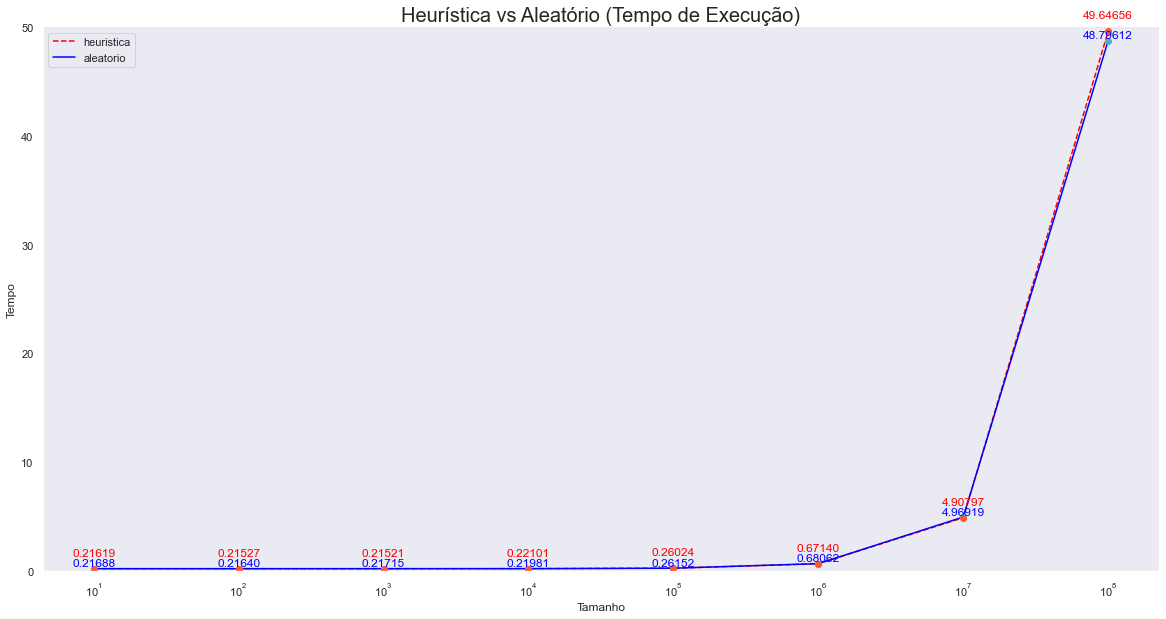

In [36]:
sns.set_theme(style="dark")

# Definindo a paleta de cores
colors = ["red", "blue"]

sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=df_temporizacao, x="tamanho", y="heuristica", linestyle='--', label="heuristica", ax=ax)
sns.lineplot(data=df_temporizacao, x="tamanho", y="aleatorio", label="aleatorio", ax=ax)

# Adicionando pontos
aleatorio_points = ax.plot(df_temporizacao['tamanho'], df_temporizacao['aleatorio'], 'o', color="#36B9CC")
heuristica_points = ax.plot(df_temporizacao['tamanho'], df_temporizacao['heuristica'], 'o', color="#FF5733")

# Adicionando texto aos pontos
for x, y in zip(df_temporizacao['tamanho'], df_temporizacao['aleatorio']):
    ax.text(x, y, f"{y:.5f}", ha='center', va='bottom', color="blue", fontsize=12)
    
for x, y in zip(df_temporizacao['tamanho'], df_temporizacao['heuristica']):
    ax.text(x, y+1, f"{y:.5f}", ha='center', va='bottom', color="red", fontsize=12)

# Personalizando eixos e título
ax.set_xlabel("Tamanho")
ax.set_ylabel("Tempo")
ax.set_ylim(0, 50)
ax.set_xscale('log')
ax.set_title("Heurística vs Aleatório (Tempo de Execução)", fontsize=20)

sns.despine()

plt.show()


### Resultado do gráfico de tempo

Acima, há uma comparação entre os valores de tempo de execução, em segundos, para cada uma das estratégias utilizadas (heurística gulosa e aleatoriedade) de acordo com uma variação para o número de filmes, sendo eles representados no eixo X em tamanho e, o tempo de execução, no eixo Y.

Como pode ser observado no gráfico acima, a diferença entre os tempos de execução para casos com menos de 100 milhões de filmes chega a ser mínima, tendo uma maior variação apenas no caso com 100 milhões de filmes, onde a diferença é mais notável e chega a cerca de 0.9s. Ou seja, é possível concluir que o número de filmes não é o principal fator responsável pela alteração no tempo de execução entre cada uma das estratégias.

### Número de filmes 

Agora, iremos comparar o desempenho de cada uma das estratégias utilizadas de acordo com o número de filmes que foram adicionados à maratona, variando o tamanho dos inputs fornecidos.

In [72]:
al_out = []
heu_out = []

for i in range (1,9):
    arquivo_heu_out = "out/heu-out-" + str(i) + ".txt"
    arquivo_al_out = "out/al-out-" + str(i) + ".txt"

    #read whats inside the file and add it to a list
    with open(arquivo_heu_out, 'r') as f:
        heu_out.append(int(f.read().strip()))
    with open(arquivo_al_out, 'r') as f:
        al_out.append(int(f.read().strip()))

#build a dataframe with the result lists of time:
df_results = pd.DataFrame({'heuristica': heu_out, 'aleatorio': al_out, 'n_filmes': [10**i for i in range(1, 9)]})
df_results.to_csv("resultados_filmes.csv", index=False)
df_results

,heuristica,aleatorio,n_filmes
0,4,3,10
1,11,11,100
2,12,12,1000
3,20,20,10000
4,23,23,100000
5,24,24,1000000
6,24,24,10000000
7,24,24,100000000


Com o `dataframe` e o `.csv` criados, agora podemos criar o gráfico de comparação.

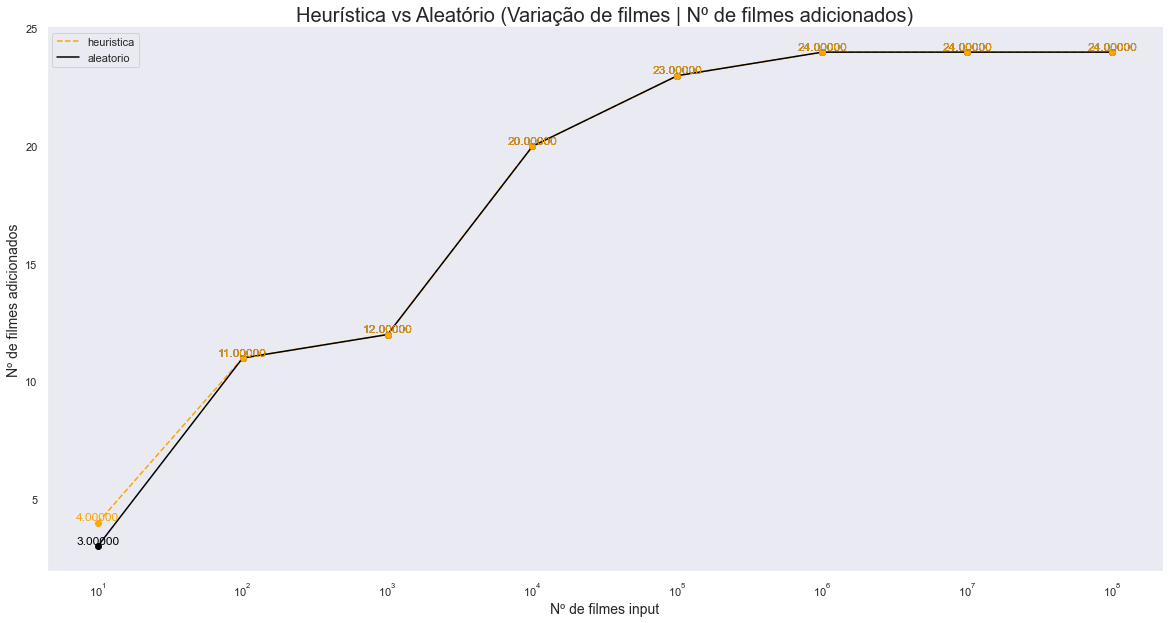

In [76]:
sns.set_theme(style="dark")

# Definindo a paleta de cores
colors = ["orange", "black"]

sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=df_results, x="n_filmes", y="heuristica", linestyle='--', label="heuristica", ax=ax)
sns.lineplot(data=df_results, x="n_filmes", y="aleatorio", label="aleatorio", ax=ax)

# Adicionando pontos
aleatorio_points = ax.plot(df_results['n_filmes'], df_results['aleatorio'], 'o', color="black")
heuristica_points = ax.plot(df_results['n_filmes'], df_results['heuristica'], 'o', color="orange")

# Adicionando texto aos pontos
for x, y in zip(df_results['n_filmes'], df_results['aleatorio']):
    ax.text(x, y, f"{y:.5f}", ha='center', va='bottom', color="black", fontsize=12)
    
for x, y in zip(df_results['n_filmes'], df_results['heuristica']):
    ax.text(x, y+0.007, f"{y:.5f}", ha='center', va='bottom', color="orange", fontsize=12)

# Personalizando eixos e título
ax.set_xlabel("Nº de filmes input", fontsize=14)
ax.set_ylabel("Nº de filmes adicionados", fontsize=14)
# ax.set_ylim(0, 0.3)
ax.set_xscale('log')
ax.set_title("Heurística vs Aleatório (Variação de filmes | Nº de filmes adicionados)", fontsize=20)

sns.despine()

plt.show()

### Resultado do gráfico de inputs X Nº de filmes adicionados

Acima, há uma comparação entre os valores de número de filmes assistidos na maratona, para cada uma das estratégias utilizadas (heurística gulosa e aleatoriedade) de acordo com uma variação para o número de inputs, sendo eles representados no eixo X em número de inputs e, o número de filmes, no eixo Y.

Como pode ser observado no gráfico acima, a diferença entre os tempos de execução para todos os casos, com exceção para quando o número de inputs é muito baixo (10 inputs), é nula. Ou seja, não há muita diferença entre as estratégias utilizadas quando varia-se o número de inputs para o resultado final obtido.

---
## Gráficos variando o Nº de categorias

### Tempo de execução
Agora, veremos como as estratégias se comparam quando variamos o número de categorias e mantemos a quantidade de filmes a mesma:

In [32]:
start = time.perf_counter()
cat_list = [1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 20, 30]

for i in range(0, 12):
    # gera o input
    tamanho = 10000
    categoria = cat_list[i]

    !./gerador-input $tamanho $categoria input-var-cat-$i
    
end = time.perf_counter()

print(f"Tempo de Execução: {end-start}s")

Tempo de Execução: 2.85072016203776s


Abaixo, estamos adicionando o necessário para receber o que é lido dos arquivos de output e, assim, adicionar a um `dataframe` e, por fim, a um `.csv` para futuras comparações.

In [39]:
tempo_heuristica = []
tempo_aleatorio = []

for i in range(0, 12):
    arquivo_in = "in/input-var-cat-" + str(i) + ".txt"
    arquivo_heu_out = "out/var-cat-heu-out-" + str(i) + ".txt"
    arquivo_al_out = "out/var-cat-al-out-" + str(i) + ".txt"


    # heuristica
    start = time.perf_counter()
    !./heuristica-gulosa < $arquivo_in > $arquivo_heu_out
    end = time.perf_counter()
    tempo_heuristica.append(end - start)

    # aleatorio
    start = time.perf_counter()
    !./aleatoriedade < $arquivo_in > $arquivo_al_out
    end = time.perf_counter()
    tempo_aleatorio.append(end - start)

In [40]:
# build a dataframe with the result lists of time:
df = pd.DataFrame({'heuristica': tempo_heuristica, 'aleatorio': tempo_aleatorio, 'n_cat': cat_list})
df.to_csv("resultados_temporizacao_var_cat.csv", index=False)

In [38]:
df_temporizacao_var_cat = pd.read_csv("resultados_temporizacao_var_cat.csv")

df_temporizacao_var_cat

,heuristica,aleatorio,n_cat
0,0.221441,0.220295,1
1,0.219058,0.221483,2
2,0.219384,0.220601,3
3,0.221256,0.223014,4
4,0.220989,0.220773,5
5,0.220582,0.220381,6
6,0.220994,0.219895,7
7,0.220515,0.219519,8
8,0.218709,0.219387,10
9,0.219241,0.221156,15


Agora, com o `dataframe` e `.csv` gerados, é possível gerar o gráfico de comparação.

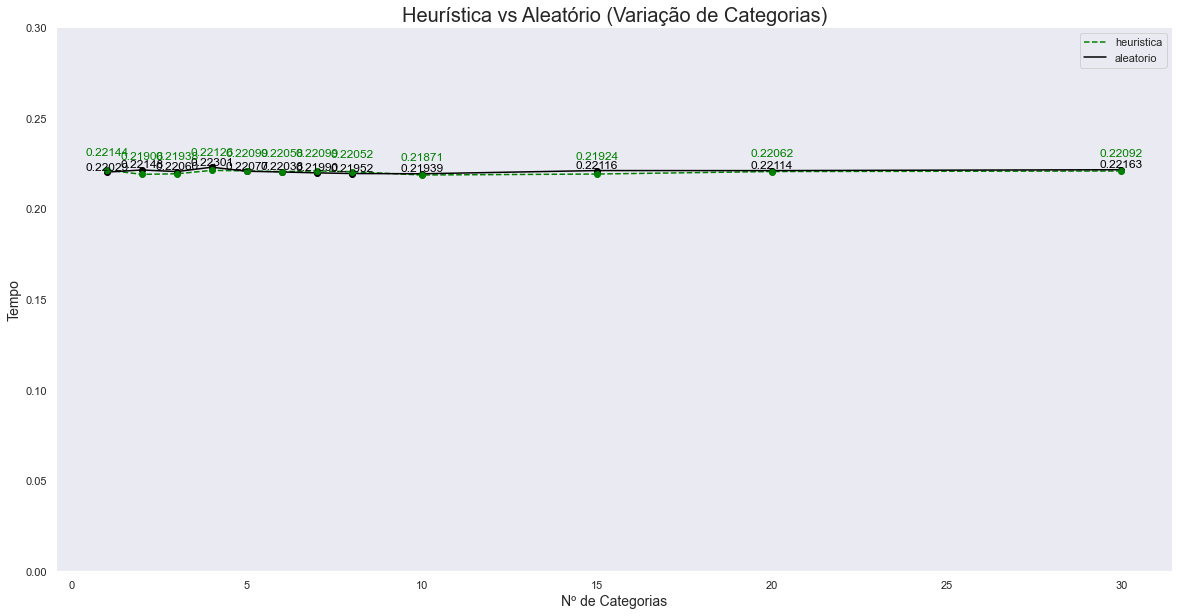

In [73]:
sns.set_theme(style="dark")

# Definindo a paleta de cores
colors = ["green", "black"]

sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=df_temporizacao_var_cat, x="n_cat", y="heuristica", linestyle='--', label="heuristica", ax=ax)
sns.lineplot(data=df_temporizacao_var_cat, x="n_cat", y="aleatorio", label="aleatorio", ax=ax)

# Adicionando pontos
aleatorio_points = ax.plot(df_temporizacao_var_cat['n_cat'], df_temporizacao_var_cat['aleatorio'], 'o', color="black")
heuristica_points = ax.plot(df_temporizacao_var_cat['n_cat'], df_temporizacao_var_cat['heuristica'], 'o', color="green")

# Adicionando texto aos pontos
for x, y in zip(df_temporizacao_var_cat['n_cat'], df_temporizacao_var_cat['aleatorio']):
    ax.text(x, y, f"{y:.5f}", ha='center', va='bottom', color="black", fontsize=12)
    
for x, y in zip(df_temporizacao_var_cat['n_cat'], df_temporizacao_var_cat['heuristica']):
    ax.text(x, y+0.007, f"{y:.5f}", ha='center', va='bottom', color="green", fontsize=12)

# Personalizando eixos e título
ax.set_xlabel("Nº de Categorias", fontsize=14)
ax.set_ylabel("Tempo", fontsize=14)
ax.set_ylim(0, 0.3)
ax.set_title("Heurística vs Aleatório (Variação de Categorias)", fontsize=20)

sns.despine()

plt.show()

### Resultado do gráfico de categorias com tempo

Acima, há uma comparação entre os valores de tempo de execução, em segundos, para cada uma das estratégias utilizadas (heurística gulosa e aleatoriedade) de acordo com uma variação para o número de categorias, com um número de filmes fixo em 10 mil, sendo eles representados no eixo X em número de categorias e, o tempo de execução, no eixo Y.

Como pode ser observado no gráfico acima, a diferença entre os tempos de execução para todos os casos é mínima ou indiferente, tendo as diferenças em questão de ms. Dessa forma, é possível concluir que o número de categorias é pouco ou nada influente quando se trata do parâmetro de tempo de execução do programa. 

### Número de filmes

Agora, iremos comparar o número de filmes adicionados à maratona de acordo com a variação do número de categorias para um valor fixo de número de filmes no input.

Abaixo, criamos listas vazias para ler os arquivos .txt de output gerados e, assim, converter em um dataframe e, finalmente, em um csv, podendo gerar um gráfico a partir desses dados.

In [62]:
al_out_cat = []
heu_out_cat = []
cat_list = []

for i in range (0,12):
    arquivo_heu_out = "out/var-cat-heu-out-" + str(i) + ".txt"
    arquivo_al_out = "out/var-cat-al-out-" + str(i) + ".txt"
    cat_list.append(i+1)

    #read whats inside the file and add it to a list
    with open(arquivo_heu_out, 'r') as f:
        heu_out_cat.append(int(f.read().strip()))
    with open(arquivo_al_out, 'r') as f:
        al_out_cat.append(int(f.read().strip()))

#build a dataframe with the result lists of time:
df_cat_results = pd.DataFrame({'heuristica': heu_out_cat, 'aleatorio': al_out_cat, 'n_cat': cat_list})
df_cat_results.to_csv("resultados_var_cat.csv", index=False)
df_cat_results

,heuristica,aleatorio,n_cat
0,1,1,1
1,2,2,2
2,5,5,3
3,13,13,4
4,11,11,5
5,14,14,6
6,24,23,7
7,24,21,8
8,24,23,9
9,24,22,10


Com o `dataframe` e o `.csv` gerados, agora podemos criar um gráfico de comparação.

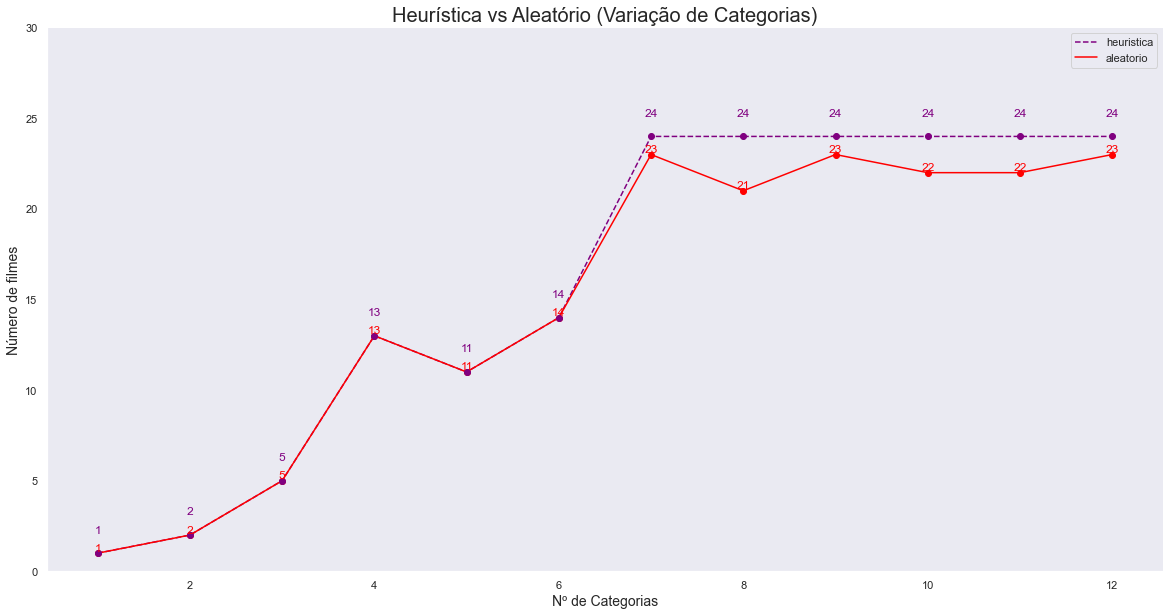

In [77]:
sns.set_theme(style="dark")

# Definindo a paleta de cores
colors = ["purple", "red"]

sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=df_cat_results, x="n_cat", y="heuristica", linestyle='--', label="heuristica", ax=ax)
sns.lineplot(data=df_cat_results, x="n_cat", y="aleatorio", label="aleatorio", ax=ax)

# Adicionando pontos
aleatorio_points = ax.plot(df_cat_results['n_cat'], df_cat_results['aleatorio'], 'o', color="red")
heuristica_points = ax.plot(df_cat_results['n_cat'], df_cat_results['heuristica'], 'o', color="purple")

# Adicionando texto aos pontos
for x, y in zip(df_cat_results['n_cat'], df_cat_results['aleatorio']):
    ax.text(x, y, f"{y:.0f}", ha='center', va='bottom', color="red", fontsize=12)
    
for x, y in zip(df_cat_results['n_cat'], df_cat_results['heuristica']):
    ax.text(x, y+1, f"{y:.0f}", ha='center', va='bottom', color="purple", fontsize=12)

# Personalizando eixos e título
ax.set_xlabel("Nº de Categorias", fontsize=14)
ax.set_ylabel("Número de filmes", fontsize=14)
ax.set_ylim(0, 30)
ax.set_title("Heurística vs Aleatório (Variação de Categorias)", fontsize=20)

sns.despine()

plt.show()

### Resultado do gráfico de categorias X Nº de filmes adicionados

Acima, há uma comparação entre os valores de número de filmes assistidos na maratona, para cada uma das estratégias utilizadas (heurística gulosa e aleatoriedade) de acordo com uma variação para o número de categorias, com um número de filmes fixo em 10 mil, sendo eles representados no eixo X em número de categorias e, o número de filmes, no eixo Y.

Como pode ser observado no gráfico acima, a diferença entre os tempos de execução para casos em que o número de categorias é 6 ou menos, é nula. No entanto, quando chegamos nos casos acima de 7 para o número de categorias, a estratégia da heurística gulosa acaba tendo uma solução melhor para o problema, sendo capaz de colocar um número maior de filmes na maratona. 